# Tutorial - Multicamera Calibration and Scene Reconstuction

This notebook outlines the process used to capture a full scene with multiple RealSense cameras. 
This includes the calibration of multiple cameras into a single global coordinate system.
The notebook uses saved example streams of 5 cameras pointed at a checkerboard for calibration. 


The following codeblocks are meant to be used as a guide explaining the built-in functions in `Dynamo`. 
Please see the examples file to see how to easily use these built-in functions in your own code. 

## Setup
First, we will import the necessary modules needed for this tutorial. 

In [69]:
import numpy as np
import pyrealsense2 as rs
import cv2
import os
import matplotlib.pyplot as plt

import pptk

%matplotlib inline

### Loading of Example Streams

Then, we will load 6 cameras, using sample `.bag` files which are saved camera streams. 
Pipeline objects will be created for each camera and stored in a dictionary to allow for virtual streaming of frames from each saved file. 

In [2]:
cameraPipelines = {}
cameraFiles = os.listdir('sample_files')
for camera in cameraFiles:
    cameraPipelines[camera] = rs.pipeline()
    config = rs.config()
    rs.config.enable_device_from_file(config, 'sample_files/'+camera)
    config.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.rgb8, 30)
    cameraPipelines[camera].start(config)


### Accessing Images from Example Streams

Now, we can access the color and depth frames from the saved streams. 
When we collect the color and depth frames, they will be misaligned due to the fact that the depth imager and color imager are offset from each other.
The `rs.align` function can be used to align the depth and camera streams based on their extrinsic relationship to each other, provided by the manufactuer. 

Now, we can convert the color frame into a black-and-white frame to easily allow for the checkerboard detection, and display the images from each of the six cameras pointed at the checkerboard.

We save the images from each color camera in the `camera_colorImages` object and the depth frames from each camera in the `camera_depthImages` object. 

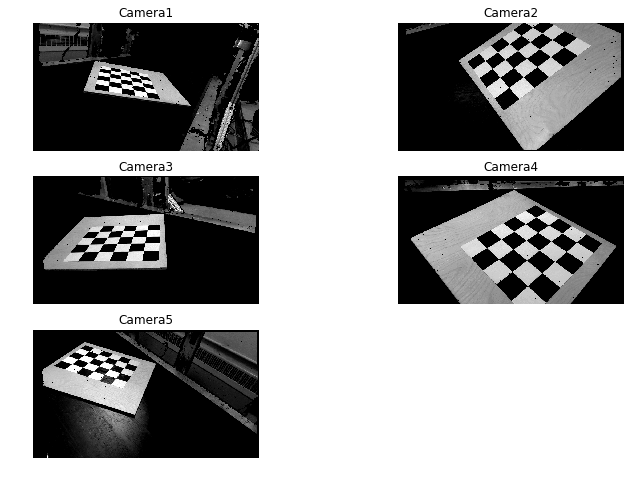

In [3]:
i = 1
camera_colorImages = {}
camera_depthImages = {}

plt.figure(figsize=(12,8))
for camera in cameraPipelines:
    frames = cameraPipelines[camera].wait_for_frames()
    align = rs.align(rs.stream.depth)
    alignedFrames = align.process(frames)
    colorFrame = alignedFrames.get_color_frame()
    depthFrame = alignedFrames.get_depth_frame()
    
    colorImage = np.asanyarray(colorFrame.get_data())
    bwImage = cv2.cvtColor(colorImage,cv2.COLOR_BGR2GRAY)
    
    camera_colorImages[camera] = bwImage
    camera_depthImages[camera] = depthFrame
    
    plt.subplot(3,2,i)
    plt.imshow(bwImage, cmap='gray',aspect='equal')
    plt.title('Camera'+str(i))
    plt.axis('off')
    i+=1
    
plt.show()

    

With each of these frames, we want to detect the checkerboard from each cameras point of view. 
We first define the height, width, and side length of the corners inside the checkerboard.

In [6]:
chessboardHeight = 4
chessboardWidth = 5
sideLength = 0.0762 #in meters

## Calibration

### Chessboard Detection

Then, we can use OpenCV's chessboad detection algorithm to find the corners of the detected chessboard for each camera's image.
The list of corners for each camera are stored in the `chessboardCorners_2D` variable.
We can see the detected corners highlighted in white on the images. 

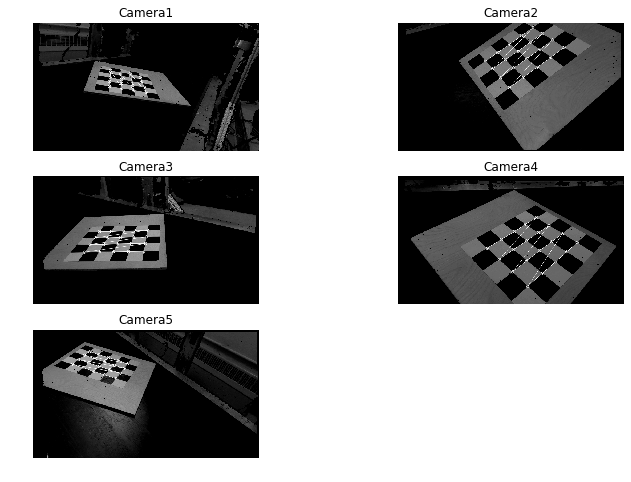

In [7]:
chessboardCorners_2D = {}
i = 1
plt.figure(figsize=(12,8))
for camera in camera_colorImages:
    chessboardImage = camera_colorImages[camera]
    chessboardFound, corners = cv2.findChessboardCorners(chessboardImage, (chessboardWidth, chessboardHeight)) #use openCV function to detect chessboard corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) #subpix criteria
    points2D = cv2.cornerSubPix(chessboardImage, corners, (11,11), (-1,-1), criteria) #further refine corners of chessboard using sub pixeling
    
    cv2.drawChessboardCorners(chessboardImage, (chessboardWidth, chessboardHeight), points2D, chessboardFound) #draw chessboard corners in white over b&w image for verification
    points2D = np.transpose(corners, (2,0,1)) 
    chessboardCorners_2D[camera] = points2D
    
    plt.subplot(3,2,i)
    plt.imshow(chessboardImage,cmap='gray', aspect='equal')
    plt.title('Camera'+str(i))
    plt.axis('off')
    i+=1

### Translating Detected 2D Points to 3D

Next, the 3D locations of the detected chessboard corners from the perspective of each camera have to be calculated from the 2D images.
The 2D images from the color frame have to be aligned to the perspective of the depth imager by using the `rs.align` function. 
Then, the intrinsics and values from the depth frame are used to calculate the 3D location of each chessboard corner from the 2D color image using the formula:

$\begin{bmatrix}x\\y\\z\end{bmatrix}_{3D} = \dfrac{\begin{bmatrix}x\\y\\z\end{bmatrix}_{2D} - \begin{bmatrix}ppx\\ppy\\0\end{bmatrix}}{
\begin{bmatrix}fx\\fy\\1\end{bmatrix} * \begin{bmatrix}z\\z\\1\end{bmatrix}}$

Where $x_{2D}$ and $y_{2D}$ are the location of the detected corner in the color frame, and $z_{3D}=z_{2D}$ is the corner's depth frame value. 
Each camera's list of 3D coordinates is stored in the `chessboardcorners_3D` variable. 



In [8]:
chessboardCorners_3D = {}
for camera in chessboardCorners_2D:
    points2D = chessboardCorners_2D[camera]
    points3D = np.zeros((3, len(points2D[0]))) #preallocate array to turn 2D chessboard corner points from camera into 3D points 
    validPoints = [False] * len(points2D[0])
 
    depthFrame = camera_depthImages[camera]
    depthIntrinsics = depthFrame.get_profile().as_video_stream_profile().get_intrinsics()
    for index in range(len(points2D[0])):
        corner = points2D[:,index].flatten()
        z = depthFrame.as_depth_frame().get_distance(round(corner[0]), round(corner[1])) #this gets the depth at the pixel for each corner
        if z != 0 and z is not None: #if the corner point has a valid depth value from the depth sensor
            validPoints[index] = True #sets points which have a depth value as valid

            #formualtion for finding 3D location of 2d point:
            points3D[0, index] = (corner[0]-depthIntrinsics.ppx)/depthIntrinsics.fx*z
            points3D[1, index] = (corner[1]-depthIntrinsics.ppy)/depthIntrinsics.fy*z
            points3D[2, index] = z
    chessboardCorners_3D[camera] = points3D

## Pose Transformation

### Calculating Rotation  and Translation Matrix
 
Now, we have the 3D coordinates of the chessboard corners from each camera's perspective. 
Next, we can find each camera's transformation matrix which translates the point-of-view of each camera to the center of the chessboard, which will be common to all cameras.
To do this, we use the Kabsch algorithm, provided by https://github.com/charnley/rmsd.

In [9]:
def kabsch(P, Q):
    """
    The optimal rotation matrix U is calculated and then used to rotate matrix
    P unto matrix Q so the minimum root-mean-square deviation (RMSD) can be
    calculated.

    Using the Kabsch algorithm with two sets of paired point P and Q, centered
    around the centroid. Each vector set is represented as an NxD
    matrix, where D is the the dimension of the space.

    The algorithm works in three steps:
    - a translation of P and Q
    - the computation of a covariance matrix C
    - computation of the optimal rotation matrix U

    http://en.wikipedia.org/wiki/Kabsch_algorithm

    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.

    Returns
    -------
    U : matrix
        Rotation matrix (D,D)

    Example
    -----
    TODO

    """

    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    # Computation of the optimal rotation matrix
    # This can be done using singular value decomposition (SVD)
    # Getting the sign of the det(V)*(W) to decide
    # whether we need to correct our rotation matrix to ensure a
    # right-handed coordinate system.
    # And finally calculating the optimal rotation matrix U
    # see http://en.wikipedia.org/wiki/Kabsch_algorithm
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return U

To calculate the Kabsch rotation matrix, we must first create a grid defining the location of the chessboard points (stored in `chessboardPoints`). 
The 3D locations of the chessboard from each camera are `observedchessboardPoints` variable. 
Both the chessboard grid and observed points are centered and then the rotation matrix (3x3) between the two is calculated. 
The translation vector (3x1) between the two is calculated by aligning the centroids of the observed chessboard points and the chessboard grid. 
 
By putting the translation vector and rotation vector together, we get a (4x4) transformation matrix for each camera. 
The transformation matrix for each camera is stored in the variable `camera_poseMats`. 

In [14]:
camera_poseMats = {}
for camera in chessboardCorners_3D:
    points3D = chessboardCorners_3D[camera]
    chessboardPoints = np.zeros((chessboardWidth*chessboardHeight,3), np.float32) #container for 3d coordinates of chessboard corners in global coordinates of chessboard
    chessboardPoints[:,:2] = np.mgrid[0:chessboardWidth, 0:chessboardHeight].T.reshape(-1,2)
    chessboardPoints = chessboardPoints.transpose() * sideLength

    chessboardPoints = chessboardPoints.transpose()
    observedchessboardPoints = points3D.transpose() 

    chessboardPointsCentered = chessboardPoints - chessboardPoints.mean(axis=0) #center global chessboard points so that reference frame is same for every camera
    observedchessboardCentered = observedchessboardPoints - observedchessboardPoints.mean(axis=0) 

    rotationMatrix = kabsch(chessboardPointsCentered, observedchessboardCentered) #calculate rotation between local coordiante system and global coordinate system

    translationVector = observedchessboardPoints.mean(axis=0) - np.matmul(chessboardPoints.mean(axis=0), rotationMatrix) #calculate translation between local and global coordinate system
    trans = -np.matmul(rotationMatrix, translationVector.transpose())

    poseMat = np.zeros((4,4)) #build 4x4 transformation matrix
    poseMat[:3,:3] = rotationMatrix
    poseMat[:3,3] = trans.flatten()
    poseMat[3,3] = 1
    camera_poseMats[camera] = poseMat
    print(poseMat)

[[-0.15808339 -0.37847918  0.9120105  -0.94229444]
 [ 0.95908686  0.16083624  0.2329895  -0.0330263 ]
 [-0.23486602  0.91152905  0.33756887 -0.3836306 ]
 [ 0.          0.          0.          1.        ]]
[[ 0.79804846 -0.5883434   0.13027165 -0.07731591]
 [ 0.53312751  0.58858661 -0.60773421  0.64592683]
 [ 0.28088027  0.55445274  0.78338268 -0.55941592]
 [ 0.          0.          0.          1.        ]]
[[-0.99024424  0.02147496  0.13767776 -0.11820625]
 [ 0.10772747 -0.50870396  0.85417508 -0.67624518]
 [ 0.0883806   0.86067364  0.50142772 -0.45366378]
 [ 0.          0.          0.          1.        ]]
[[-0.73431709  0.47535649 -0.48457675  0.5541254 ]
 [-0.67811511 -0.5459196   0.49206879 -0.15439189]
 [-0.03063185  0.68993333  0.72322451 -0.49917882]
 [ 0.          0.          0.          1.        ]]
[[ 0.94569444  0.31583612 -0.07687373  0.58888689]
 [-0.25346662  0.56843408 -0.78271155  1.07983318]
 [-0.20351093  0.75969089  0.61761886 -0.62329977]
 [ 0.          0.          

## Scene Reconstruction

Now, when we are ready to capture data from the cameras, we can generate a pointcloud for each camera and align it to the common global coordinate system by multiplying each camera's pointcloud by its own transformation matrix.
Each camera's pointcloud can then be combined into a single pointcloud which encompasses the whole scene. 

We display the scene using the `pptk` toolkit. 
The reconstucted scene from multiple cameras is shown below.

In [74]:
allPoints = np.empty((0,6))
for camera in camera_poseMats:
    colorFrame = camera_colorImages[camera]
    depthFrame = np.asarray(camera_depthImages[camera].get_data())
    poseMat = camera_poseMats[camera]
    cameraIntrinsics = camera_depthImages[camera].get_profile().as_video_stream_profile().get_intrinsics()

    #calculating pointcloud per camera
    [height,width] = np.array(depthFrame.shape)
    nx = np.linspace(0, width-1, width)
    ny = np.linspace(0, height-1, height)
    u, v = np.meshgrid(nx, ny)
    x = (u.flatten() - cameraIntrinsics.ppx)/cameraIntrinsics.fx
    y = (v.flatten() - cameraIntrinsics.ppy)/cameraIntrinsics.fy
    z = depthFrame.flatten() / 1000
    x = np.multiply(x,z)
    y = np.multiply(y,z)
    points = np.asanyarray([x,y,z]) 
    
    points3x4 = np.vstack((points, np.ones((1,points.shape[1])))) #append 1s to the list of points so that we can multiply by a 4x4 matrix
    pointsTransformed = np.matmul(poseMat, points3x4) #muliply by 4x4 transformation matrix
    
    #add color information
    r = colorFrame.flatten().astype(int)
    allPoints = np.append(allPoints,np.hstack((pointsTransformed[0:3].T,
                                               np.asarray([r,r,r]).T)),axis=0)
    

v=pptk.viewer(allPoints[:,0:3], allPoints[:,3:6])
import time
time.sleep(5)
v.capture('screenshot.png')
time.sleep(5)
v.close()

![](screenshot.png)